Датасет guide_raw.csv содержит разговоры Kaspi-гидов с клиентами. Цель Kaspi-гида - научить клиента пользоваться сервисами экосистемы Kaspi. 

Нам интересно, что отличает эффективные разговоры от неэффективных, и какие гиды лучше помогают клиентам разобраться с сервисами Kaspi, и как им это удается. Эффективным разговором мы считаем, если клиент совершил платеж (телефон, коммуналки и т.д.) на Kaspi.kz в течении 3х дней после разговора с гидом.

Сможет ли речевая аналитика нам в этом помочь?


1) Откройте файл **'input/guide_raw.csv'**. 
- Текст в поле **'txt'** был распознан из аудиозаписи разговора автоматически. Считаете ли вы, что система распознавания звука отлично справилась со своей работой?
- Сколько в файле записей?
- Какой рейндж дат по нашим данным?
- Сколько гидов охватывают данные?
- Опишите статистики по гидам (сколько минимум/максимум разговоров, сколько в среднем разговоров, медиана)

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv("data/guide_raw.csv", index_col=0)

In [3]:
df.head()

,personnel_num,guide_date,guide_time,conversion,target_3_days,txt
0,1512,18-05-2018,14:44,Нет конверсии,0,сейчас скажу своим да и ещё что-то он на сайте...
1,1512,21-05-2018,9:46,Конверсия платежа,1,спасибо до свидания хорошо я рада была вам пом...
2,1512,25-05-2018,14:25,Конверсия посещения,0,будет готово ставка финансовые есть как это от...
3,1820,27-05-2018,12:41,Конверсия платежа,1,сейчас все закрыто хорошо узнаю все делать оче...
4,1820,18-05-2018,10:12,Нет конверсии,0,окей справ после а сколько апелляционный понят...


2) Запустите следующий код. 
- Что Вы наблюдаете?
- Может ли у слова быть несколько нормальных форм? 
- Проверьте, какие нормальные формы могут быть у слова 'стали'
- Как получить нормальную форму слова? 

In [4]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
print(morph.parse('Стали'))
print("\n")
print(morph.parse('Стали')[0].normal_form)

[Parse(word='стали', tag=OpencorporaTag('VERB,perf,intr plur,past,indc'), normal_form='стать', score=0.984662, methods_stack=((<DictionaryAnalyzer>, 'стали', 904, 4),)), Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn sing,gent'), normal_form='сталь', score=0.003067, methods_stack=((<DictionaryAnalyzer>, 'стали', 13, 1),)), Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn sing,datv'), normal_form='сталь', score=0.003067, methods_stack=((<DictionaryAnalyzer>, 'стали', 13, 2),)), Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn sing,loct'), normal_form='сталь', score=0.003067, methods_stack=((<DictionaryAnalyzer>, 'стали', 13, 5),)), Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn plur,nomn'), normal_form='сталь', score=0.003067, methods_stack=((<DictionaryAnalyzer>, 'стали', 13, 6),)), Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn plur,accs'), normal_form='сталь', score=0.003067, methods_stack=((<DictionaryAnalyzer>, 'стали', 13, 9),))]


стать


3) Откройте файл **'preprocessing.py'**. 
- Какие стоп-слова используются? Логичны ли они?
- Используется лемматизация или стемминг?
- Запустите код в следующей ячейке. Сколько записей в аутпут файле? А сколько должно быть? Сделайте соответствующие изменения в файле, получите результат. (Для того, чтобы Jupyter увидел изменения в файле, возможно, понадобится перезапустить kernel)
- Соедините результаты препроцессинга с исходным датафреймом (data/guide_raw.csv)

In [172]:
%%time
import preprocessing as p

p.preprocess('data/guide_raw.csv', 'data/output.csv')


CPU times: user 2min 45s, sys: 1.42 s, total: 2min 46s
Wall time: 3min 17s


In [173]:
df_preprocessed = pd.read_csv("data/output.csv", header=None)

In [174]:
preprocessed = df_preprocessed[1].apply(lambda text: text[2:-2])

In [175]:
sum(preprocessed.str.contains("mochbzdravstvovatb"))

0

4) Обучите word2vec (библиотека gensim):
- в корпусе слов оставьте только слова, повторяющиеся более одного раза
- обучите word2vec модель. На что влияют параметры size, window, min_count? Остановимся на size = 100
- создайте датафрейм, где индексами будут слова, а колонками - значения по измерениям получившихся векторов

In [176]:
from gensim.models import Word2Vec

In [177]:
import collections
def build_corpus(words):
    count = collections.Counter(words).most_common()
    corpus, ignore_corpus = [], []
    for word, _ in count:
        if _ > 1:
            corpus.append(word)
        else:
            ignore_corpus.append(word)
    return corpus, ignore_corpus

In [189]:
corpus, ignore_corpus = build_corpus(" ".join(preprocessed.tolist()).split())

In [190]:
cleaned_texts = [[word for word in text.split() if word not in ignore_corpus] for text in preprocessed.tolist()]


In [191]:
model = Word2Vec(cleaned_texts, size=100, window=5, min_count=1, workers=4)
model.train(cleaned_texts, total_examples=len(corpus), epochs=30)

(17511408, 21064260)

In [192]:
model.save("word2vec.model")

In [193]:
model = Word2Vec.load("word2vec.model")

In [195]:
list_vector = [(word, model[word]) for word in map(str, corpus)]

/Users/dosya/Envs/ds/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [196]:
values = list(zip(*list_vector))[0]
vectors = np.matrix(list(zip(*list_vector))[1])

In [199]:
vector_df = pd.DataFrame(vectors, columns=list(map(str, np.arange(0, 100))), index=values)

In [200]:
vector_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
mochb,0.022834,-0.410565,-0.288082,0.887976,0.413645,0.692833,0.901964,1.069723,-0.342472,0.818680,...,0.422837,0.644179,0.107509,0.621993,0.189433,-1.029824,0.159382,-0.227946,0.647759,0.666026
karta,0.640752,-0.812185,-1.009775,-0.420308,0.527061,-0.456083,-1.172094,-1.570992,-0.489798,-0.001790,...,1.303714,-1.857771,-0.851817,-1.227424,0.013430,-1.031063,0.512186,0.462186,0.976066,-0.049211
telefon,-0.724853,-0.081017,1.195451,0.026281,-1.920824,1.836485,1.190427,0.338019,1.923863,1.795209,...,-0.075222,0.574347,-1.884483,-1.052101,0.166867,0.308076,0.066141,0.605871,-0.142841,-1.298102
nomer,-0.117357,0.472881,0.575181,-1.443722,-0.927350,1.842047,-2.119892,0.071958,0.606527,1.165539,...,-2.160181,0.637105,-2.040051,-0.213874,0.147874,-0.828449,1.998708,2.200392,-0.030605,-1.729700
parolb,-0.405843,0.970422,1.058649,0.507387,-0.010669,1.021823,0.719640,0.033191,0.132268,2.540282,...,-1.904765,-0.949125,-1.200662,-0.207477,-1.201797,1.042380,2.322273,2.984717,-0.204784,-0.622183


5) Визуализируем то, что получилось.

- Нормализуйте данные по каждой колонке, чтобы значения были в интервале [0, 1]
- Используя dimensionality reduction (PCA/LDA..), спроецируйте 100-мерные векторы на двумерное пространство
- Выведите результат с метками (чтобы каждой точке на графике соответствовало слово)


In [202]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [203]:
scaled_vector_df = vector_df.copy()

In [204]:
scaled_vector_df[:] = scaler.fit_transform(vector_df)

In [205]:
scaled_vector_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
mochb,-0.058448,-0.674233,-0.732616,1.901855,1.172914,1.532069,1.959302,2.162843,-0.431590,1.619982,...,0.617476,1.081254,-0.157955,1.157849,0.335916,-1.915055,0.215008,-0.590755,1.316959,1.146026
karta,1.023799,-1.488556,-2.002470,-0.676224,1.388782,-0.624531,-2.341578,-3.394044,-0.702053,0.130273,...,2.381917,-3.936335,-1.931306,-2.569980,-0.002014,-1.917284,0.899265,0.809641,1.941075,-0.190122
telefon,-1.367977,-0.006040,1.877731,0.203816,-3.270325,3.678787,2.557475,0.623110,3.728972,3.393046,...,-0.380162,0.941208,-3.840227,-2.216585,0.292589,0.492045,0.034167,1.101203,-0.185980,-2.523201
nomer,-0.303984,1.117045,0.786336,-2.692945,-1.379428,3.689226,-4.306984,0.063235,1.310593,2.249768,...,-4.556443,1.067066,-4.127801,-0.526989,0.256122,-1.552748,3.782351,4.336765,0.027381,-3.329478
parolb,-0.809250,2.125858,1.637021,1.151873,0.365309,2.149606,1.581226,-0.018343,0.439943,4.745859,...,-4.044831,-2.114071,-2.576159,-0.514095,-2.335271,1.813179,4.409901,5.928297,-0.303735,-1.260503


In [206]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [207]:
pca = PCA(n_components=2)
pca_scaled_vector_df = pca.fit_transform(scaled_vector_df)

In [211]:
y=pca_scaled_vector_df.T[1]
z=pca_scaled_vector_df.T[0]
n=values

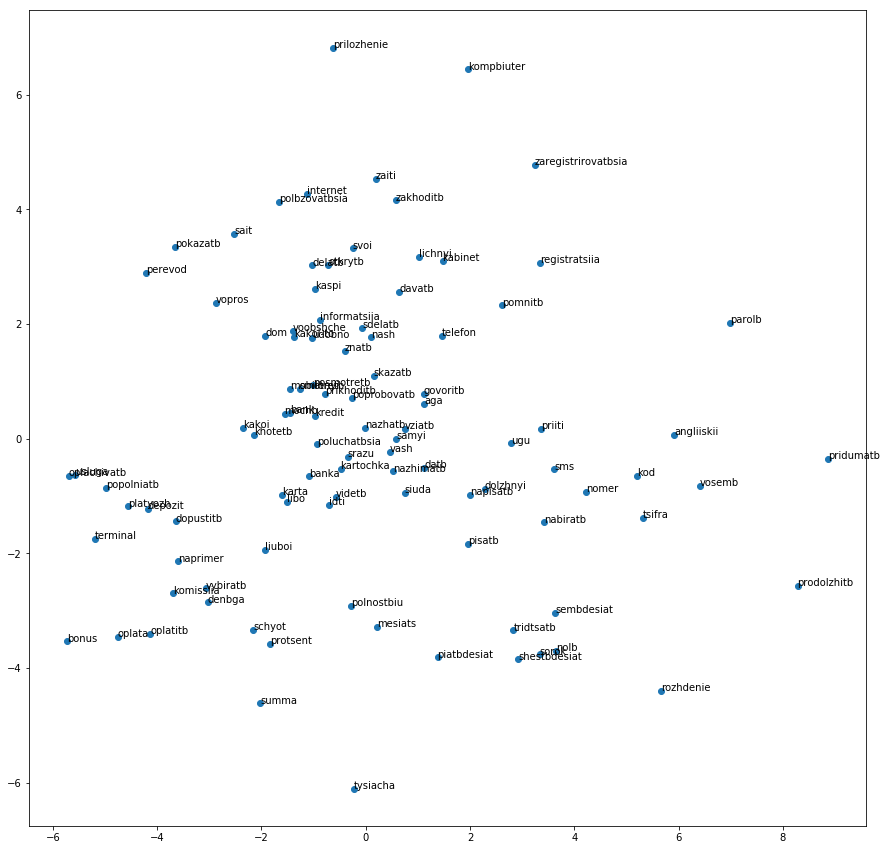

In [107]:
y=pca_scaled_vector_df.T[1]
z=pca_scaled_vector_df.T[0]
n=values

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i],y[i]))

6) Помните свойство word2vec, что слова, близкие в векторном пространстве, находятся примерно в одинаковом контексте? Быть может, мы сможем выделить основные тематики в разговорах?
- кластеризуйте слова на 15 кластеров, используя любой алгоритм на ваш выбор (но с заданным кол-вом кластеров)
- Выведите картинку точек на графике (используйте координаты двумерного пространства с прошлого задания), окрасив разные кластеры в разные цвета. Метки слов не нужны
- Удовлетворяют ли вас результаты кластеризации? Почему?

In [212]:
from sklearn.cluster import KMeans

In [272]:
clf = KMeans(n_clusters=15)
clustered = clf.fit(pca_scaled_vector_df).labels_

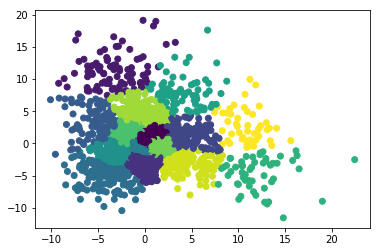

In [273]:
plt.scatter(y, z, c=clustered, cmap="viridis")

7) По каждому кластеру выведите список слов и попробуйте сформировать тему разговора, которой принадлежат эти кластеры

In [270]:
clf_full = KMeans(n_clusters=15)
clustered_full = clf_full.fit(scaled_vector_df).labels_

In [275]:
clustered_full.shape

(8869,)

In [271]:
scaled_vector_df[clustered_full==8].index

Index(['summa', 'khotetb', 'oplatitb', 'oplata', 'naprimer', 'schyot',
       'vybiratb', 'dopustitb', 'vykhoditb', 'potratitb', 'koshelyok',
       'popolnitb', 'otkuda', 'vybratb', 'zaplatitb', 'zakinutb', 'primer',
       'dosrochno', 'priam', 'priamo', 'ostatok', 'proveriatb', 'pogasitb',
       'zakhotetb', 'postupitb', 'dostatochno', 'sembia', 'segodniashnii',
       'galochka', 'ukhoditb', 'vnesti', 'khvatatb', 'sobiratb', 'spisatb',
       'ubiratb', 'zaranee', 'sekonomitb', 'spisyvatbsia', 'pisatbsia',
       'proizvoditb', 'sposob', 'spisyvatb', 'ezhemesiachno', 'knopochka',
       'tarif', 'ekonomitb', 'vybiratbsia', 'spisatbsia', 'kopatb',
       'chastichno', 'pereplachivatb', 'perechislitb', 'snizhatb', 'zakrytie',
       'kopeechka'],
      dtype='object')

In [239]:
preprocessed_df1 = pd.read_csv("data/guide_df.csv", index_col=0)

In [240]:
preprocessed_df1.head()

,personnel_num,guide_date,guide_time,conversion,target_3_days,txt,txt_preprocessed
0,1512,18-05-2018,14:44,Нет конверсии,0,сейчас скажу своим да и ещё что-то он на сайте...,skazatb svoi eshchyo chto-to sait karta obiaza...
1,1512,21-05-2018,9:46,Конверсия платежа,1,спасибо до свидания хорошо я рада была вам пом...,spasibo svidanie rada pomochb dobryi svidanie ...
2,1512,25-05-2018,14:25,Конверсия посещения,0,будет готово ставка финансовые есть как это от...,gotovyi stavka finansovyi stavka semnadtsatb s...
3,1820,27-05-2018,12:41,Конверсия платежа,1,сейчас все закрыто хорошо узнаю все делать оче...,zakrytyi uznavatb delatb ochenb udobno sredi t...
4,1820,18-05-2018,10:12,Нет конверсии,0,окей справ после а сколько апелляционный понят...,okei sprava skolbko apelliatsionnyi poniatno o...


In [250]:
preprocessed_df1["Weekday"] = pd.to_datetime(preprocessed_df1.guide_date).apply(lambda x: x.weekday())
preprocessed_df1["Hour"] = pd.to_datetime(preprocessed_df1.guide_time).apply(lambda x: x.hour)

In [252]:
preprocessed_df2 = preprocessed_df1.drop(["guide_date", "guide_time", "personnel_num", "txt", "conversion"], axis=1)

In [266]:
preprocessed_df2["Weekday"] = preprocessed_df2["Weekday"].apply(lambda x: x % 2 == 0)

In [268]:
preprocessed_df2["Hour"] = preprocessed_df2["Hour"].apply(lambda x: x <= 14)

In [269]:
preprocessed_df2.head()

,target_3_days,txt_preprocessed,Weekday,Hour
0,0,skazatb svoi eshchyo chto-to sait karta obiaza...,True,True
1,1,spasibo svidanie rada pomochb dobryi svidanie ...,True,True
2,0,gotovyi stavka finansovyi stavka semnadtsatb s...,True,True
3,1,zakrytyi uznavatb delatb ochenb udobno sredi t...,True,True
4,0,okei sprava skolbko apelliatsionnyi poniatno o...,True,True


8) Можем ли мы предсказать, был ли платеж после разговора с гидом, основываясь только на word2vec признаках?
- Возьмите среднее векторное представление по каждому тексту и используйте его для тренировки модели с таргетом 'target_3_days'
- А что, если добавить информацию о гиде? У какой модели лучше результаты?

In [276]:
preprocessed_df2.shape

(1796, 4)

In [281]:
preprocessed_df2["cleaned_text"] = preprocessed_df2["txt_preprocessed"].apply(lambda text: " ".join([word for word in text.split() if word not in ignore_corpus]) )

In [292]:
preprocessed_df2.head()

,target_3_days,txt_preprocessed,Weekday,Hour,cleaned_text
0,0,skazatb svoi eshchyo chto-to sait karta obiaza...,True,True,skazatb svoi eshchyo chto-to sait karta obiaza...
1,1,spasibo svidanie rada pomochb dobryi svidanie ...,True,True,spasibo svidanie rada pomochb dobryi svidanie ...
2,0,gotovyi stavka finansovyi stavka semnadtsatb s...,True,True,gotovyi stavka finansovyi stavka semnadtsatb s...
3,1,zakrytyi uznavatb delatb ochenb udobno sredi t...,True,True,zakrytyi uznavatb delatb ochenb udobno sredi t...
4,0,okei sprava skolbko apelliatsionnyi poniatno o...,True,True,okei sprava skolbko apelliatsionnyi poniatno o...


In [295]:
matrix = []
for word in preprocessed_df2["cleaned_text"][0].split():
    matrix.append(model[word])

/Users/dosya/Envs/ds/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


KeyError: "word 'eshchyo' not in vocabulary"

In [297]:
model['eshchyo']

/Users/dosya/Envs/ds/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


KeyError: "word 'eshchyo' not in vocabulary"

**Финальные вопросы: что отличает хорошего гида от плохого? Какие дополнительные данные помогли бы ответить на этот вопрос?**